# 0200 ランダムフォレスト回帰
- 多変数が複雑に関連し合っている場合、単純な線形モデルよりも決定木モデルのほうが精度が高い場合がある。
- 特に、変数同士の非線形な関係を捉えやすい
- 交互作用の検出力高

ただし、
- モデルの複雑性が増す
- ハイパーパラメータがブラックボックス化しやすい

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from constants import *

plt.style.use('ggplot')
sns.set_palette('flare')

%load_ext autoreload
%autoreload 2

## 0. データ取得

In [2]:
raw_data = pd.read_csv(os.path.join(RAW_PATH, 'train.csv'), index_col=0)
raw_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### RFR用にデータを整形
順序・名義尺度はダミー変数化するため、基本的な特徴量のみ作成。
#### 元のデータセットから残すカラムを指定

In [62]:
cols_remained = [
    'MSSubClass','LotFrontage', 'Street', 'Utilities',
    'HouseStyle', 'OverallQual', 'ExterQual', 'KitchenQual', 'Heating',
    'Functional', 'GarageCars']

all_data = pd.DataFrame(index=raw_data.index)

for col in cols_remained:
    all_data[col] = raw_data[col]

In [74]:
raw_data['log_price'] = np.log(raw_data['SalePrice'])

all_data['MSSubClass'] = raw_data['MSSubClass'].astype(str)

all_data['log_price'] = raw_data['log_price']

all_data['total_sf'] = raw_data['1stFlrSF'] + raw_data['2ndFlrSF'].fillna(0) + raw_data['TotalBsmtSF'].fillna(0)

all_data['log_total_sf'] = np.log(all_data['total_sf'])

all_data['has_2nd'] = (raw_data['2ndFlrSF'] > 0).astype(int)

all_data['has_bsmt'] = (raw_data['TotalBsmtSF'] > 0).astype(int)

all_data['has_garage'] = (raw_data['GarageArea'] > 0).astype(int)

all_data['has_pool'] = (raw_data['PoolArea'] > 0).astype(int)

all_data['has_central_air'] = (raw_data['CentralAir'] == 'Y').astype(int)

all_data['has_fireplace'] = (raw_data['Fireplaces'] > 0).astype(int)

all_data['house_age'] = raw_data['YrSold'] - raw_data['YearBuilt']

all_data['remod_age'] = raw_data['YrSold'] - raw_data['YearRemodAdd']

all_data['total_porch_sf'] = raw_data['OpenPorchSF'] + raw_data['EnclosedPorch'].fillna(0) + raw_data['3SsnPorch'].fillna(0) + raw_data['ScreenPorch'].fillna(0)

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

neighbor_log_price = raw_data.groupby('Neighborhood')['log_price'].mean().sort_values(ascending=False)
neighbor_log_price_stdsclaled = std_scaler.fit_transform(neighbor_log_price.values.reshape(-1, 1))
neighbor_log_price_dict = dict(zip(neighbor_log_price.index, neighbor_log_price_stdsclaled))
all_data['neighbor_log_price_stdscaled'] = raw_data['Neighborhood'].map(neighbor_log_price_dict).astype(float)

all_data['built_era'] = pd.cut(
    raw_data['YearBuilt'],
    bins=[1800, 1900, 1940, 1960, 1980, 2000, 2020],
    labels=['pre_1900', '1900-1940', '40-60', '60-80', '80-2000', 'post-2000']
)

year_price = raw_data.groupby('YearBuilt')['SalePrice'].mean()
year_price = year_price.rolling(window=5, center=True).mean()
year_price = year_price.interpolate(method='linear')
year_price = year_price.fillna(raw_data.groupby('YearBuilt')['SalePrice'].mean())
all_data['year_price'] = raw_data['YearBuilt'].map(year_price)

all_data.drop(['total_sf', 'built_era'], axis=1, inplace=True)

all_data.columns

Index(['MSSubClass', 'LotFrontage', 'Street', 'Utilities', 'HouseStyle',
       'OverallQual', 'ExterQual', 'KitchenQual', 'Heating', 'Functional',
       'GarageCars', 'log_price', 'log_total_sf', 'has_2nd', 'has_bsmt',
       'has_garage', 'has_pool', 'has_central_air', 'has_fireplace',
       'house_age', 'remod_age', 'total_porch_sf',
       'neighbor_log_price_stdscaled', 'year_price'],
      dtype='object')

In [75]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        all_data[col].fillna('None')
    if all_data[col].dtype == 'float64' or all_data[col].dtype == 'int64':
        all_data[col].fillna(0)

all_data.head()

,MSSubClass,LotFrontage,Street,Utilities,HouseStyle,OverallQual,ExterQual,KitchenQual,Heating,Functional,...,has_bsmt,has_garage,has_pool,has_central_air,has_fireplace,house_age,remod_age,total_porch_sf,neighbor_log_price_stdscaled,year_price
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,Pave,AllPub,2Story,7,Gd,Gd,GasA,Typ,...,1,1,0,1,0,5,5,61,0.392477,227387.363668
2,20,80.0,Pave,AllPub,1Story,6,TA,TA,GasA,Typ,...,1,1,0,1,1,31,31,0,0.922961,166794.831439
3,60,68.0,Pave,AllPub,2Story,7,Gd,Gd,GasA,Typ,...,1,1,0,1,1,7,6,42,0.392477,223657.905932
4,70,60.0,Pave,AllPub,2Story,7,TA,Gd,GasA,Typ,...,1,1,0,1,1,91,36,307,0.518880,124018.557143
5,60,84.0,Pave,AllPub,2Story,8,Gd,Gd,GasA,Typ,...,1,1,0,1,1,8,8,84,1.897994,222266.190377


In [76]:
data = pd.get_dummies(all_data, drop_first=True, dtype=int)
data.columns

Index(['LotFrontage', 'OverallQual', 'GarageCars', 'log_price', 'log_total_sf',
       'has_2nd', 'has_bsmt', 'has_garage', 'has_pool', 'has_central_air',
       'has_fireplace', 'house_age', 'remod_age', 'total_porch_sf',
       'neighbor_log_price_stdscaled', 'year_price', 'MSSubClass_160',
       'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30',
       'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60',
       'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85',
       'MSSubClass_90', 'Street_Pave', 'Utilities_NoSeWa', 'HouseStyle_1.5Unf',
       'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf',
       'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl',
       'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'KitchenQual_Fa',
       'KitchenQual_Gd', 'KitchenQual_TA', 'Heating_GasA', 'Heating_GasW',
       'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'Functional_Maj2',
       'Functional_Min1', 'Functional_M

## 1. 単純なRFR実装
まずは、全ての変数を単純なランダムフォレスト回帰に入れ込んで予測してみる

In [77]:
from sklearn.model_selection import train_test_split

X = data.drop('log_price', axis=1)
y = data['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

test = RandomForestRegressor(random_state=0, n_jobs=-1)
test.fit(X_train, y_train)

y_pred = test.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Test RFR')
print(f'  RMSE: {rmse}')
print(f'  R2: {r2}')

Test RFR
  RMSE: 0.12138609745047756
  R2: 0.8861991328426317


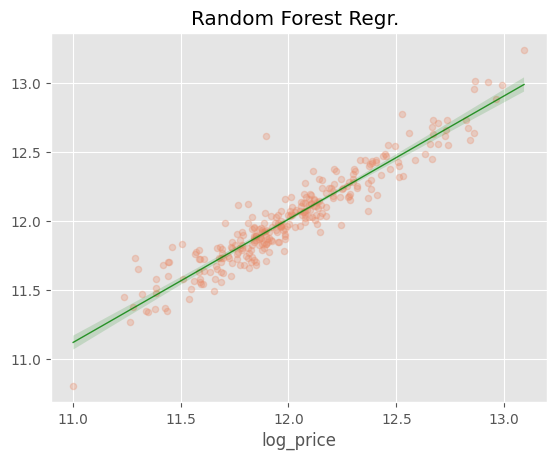

In [79]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Random Forest Regr. ")
plt.show()

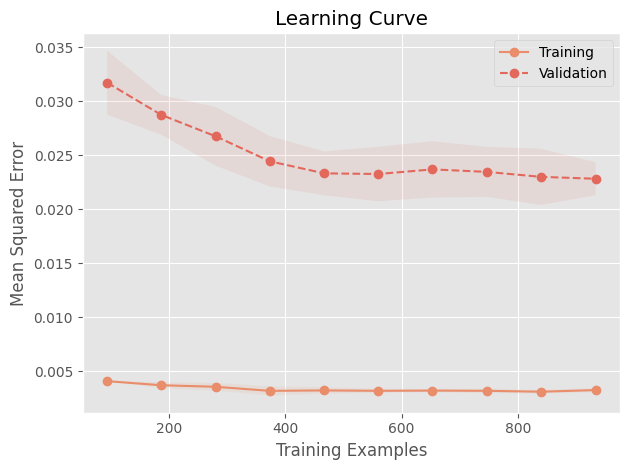

In [80]:
from utils import plot_learning_curve

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

plot_learning_curve(RandomForestRegressor(random_state=11, n_jobs=-1), X_train, y_train)
plt.show()

#### 明らかに過学習
特徴量の重要度を測定する。

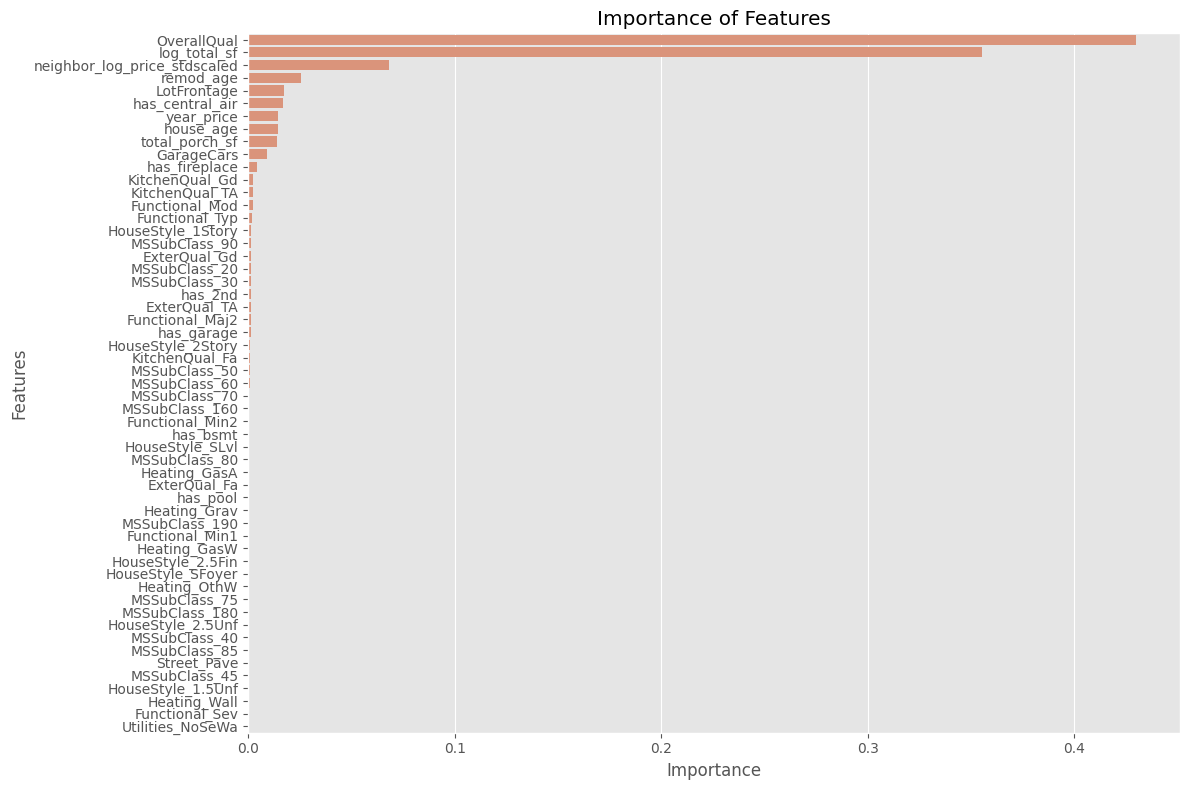

,feature,importance
1,OverallQual,0.429710
3,log_total_sf,0.355437
13,neighbor_log_price_stdscaled,0.068047
11,remod_age,0.025551
0,LotFrontage,0.017159
8,has_central_air,0.016827
14,year_price,0.014577
10,house_age,0.014277
12,total_porch_sf,0.013785
2,GarageCars,0.009192


In [81]:
from utils import plot_feature_importance

importance = plot_feature_importance(test, X.columns, type='feature_importances')
importance = importance[importance['importance'] > 0.005]
importance

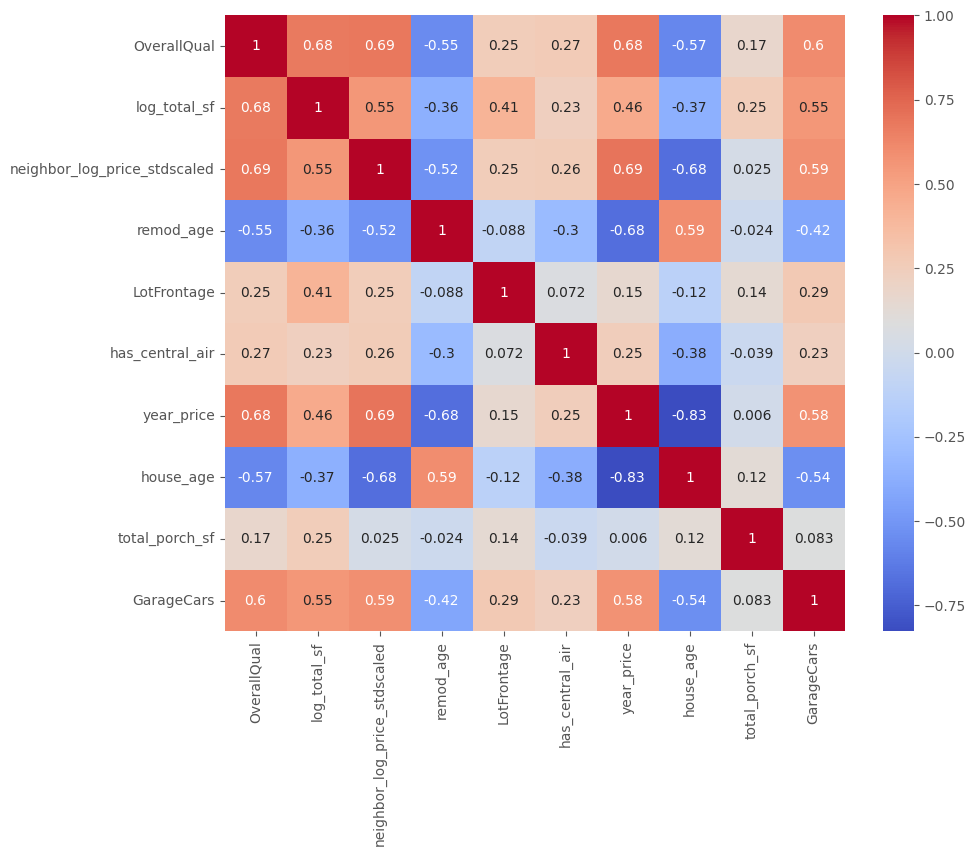

In [82]:
col = list(importance['feature'])

corr_mat = data[col].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.show()

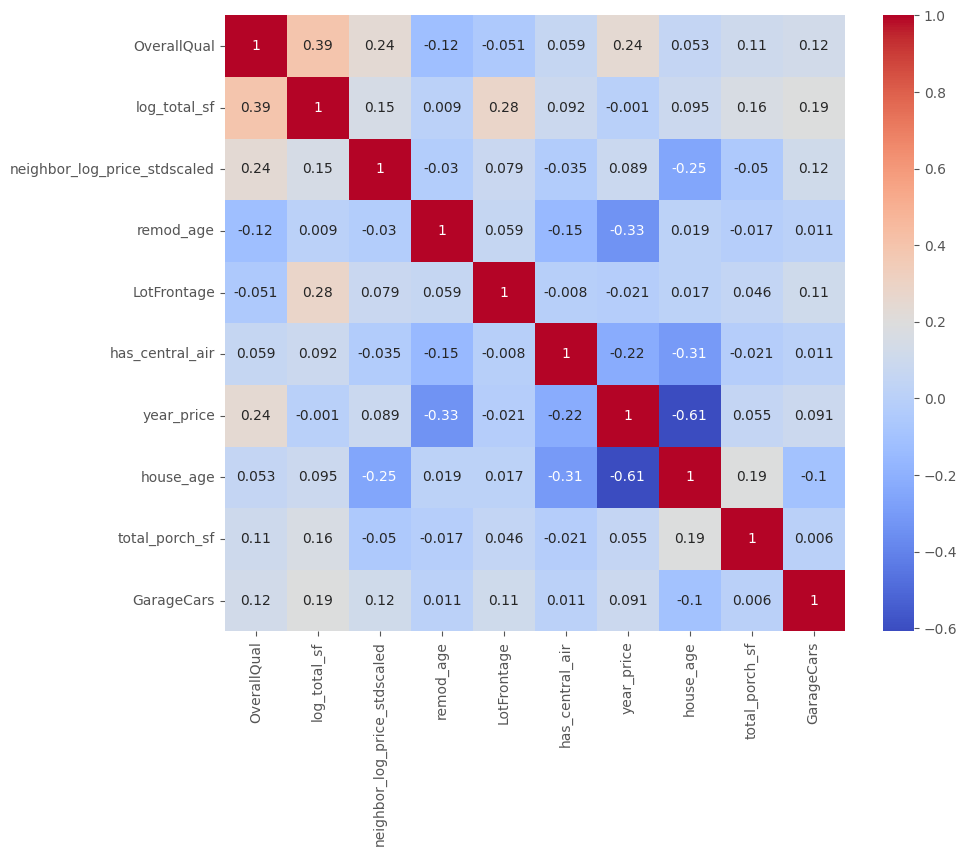

In [83]:
import pingouin as pg
plt.figure(figsize=(10, 8))

pcorr_mat = pg.pcorr(data[col]).round(3)

sns.heatmap(pcorr_mat, annot=True, cmap='coolwarm')
plt.show()

In [84]:
import optuna

X = data.drop('log_price', axis=1)
y = data['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=33)

def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_int('max_features', 1, 20)
        }
    
    rfr = RandomForestRegressor(
        **params,
        n_jobs=-1,
        random_state=87)
    
    rfr.fit(X_train, y_train)
    
    y_pred = rfr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    
    return rmse

In [85]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200, n_jobs=-1)

[I 2025-05-09 16:56:21,946] A new study created in memory with name: no-name-25f1069c-bd68-478b-80a2-19d6bcbe18fe
[I 2025-05-09 16:56:22,522] Trial 5 finished with value: 0.14658661330330186 and parameters: {'n_estimators': 37, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 17}. Best is trial 5 with value: 0.14658661330330186.
[I 2025-05-09 16:56:22,530] Trial 3 finished with value: 0.1523970759877634 and parameters: {'n_estimators': 59, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 13}. Best is trial 5 with value: 0.14658661330330186.
[I 2025-05-09 16:56:22,534] Trial 2 finished with value: 0.14995078753312174 and parameters: {'n_estimators': 68, 'max_depth': 29, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 12}. Best is trial 5 with value: 0.14658661330330186.
[I 2025-05-09 16:56:22,538] Trial 6 finished with value: 0.1464812522640167 and parameters: {'n_estimators': 43, 'max_depth': 24, 'min_samples

In [86]:
study.best_params, study.best_value

({'n_estimators': 89,
  'max_depth': 29,
  'min_samples_split': 5,
  'min_samples_leaf': 2,
  'max_features': 17},
 0.14311590709465785)

In [87]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [min_samples_split (IntDistribution):
                                0.003431226015421862<extra></extra>, max_depth
                                (IntDistribution):
                                0.0041449300903383226<extra></extra>, n_estimators
                                (IntDistribution):
                                0.004198419310948213<extra></extra>,
                                min_samples_leaf (IntDistribution):
                                0.02925196560796904<extra></extra>, max_features
                                (IntDistribution):
                                0.9589734589753225<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, <0.01, 0.03, 0.96],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.003431226015421862, 0.0041449300903383226,
                    0.004198419310948213, 0.02925196560796904, 0.9589734589753225],
              'y': [min_samples_split, max_depth, n_estimators, min_samples_leaf,
                    max_features]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [89]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
                    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
                    123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
                    135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
                    147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
                    159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
                    171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
                    183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
                    195, 196, 197, 198, 199],
              'y': [0.1480821242671468, 0.1796501173947842, 0.14995078753312174,
                    0.1523970759877634, 0.14680973873013248, 0.14658661330330186,
                    0.1464812522640167, 0.15265334538149983, 0.14470421966294938,
                    0.17466700838198973, 0.14824210312032585, 0.15524473288991691,
                    0.1476195877541835, 0.1465129366522804, 0.14956102291375087,
                    0.16734449029337214, 0.1848624227873484, 0.16168480144727101,
                    0.1607863862890282, 0.15579755865189512, 0.15732751705061865,
                    0.15958772233609642, 0.14796392301495406, 0.1486643370655745,
                    0.14837644443396916, 0.32600367376614625, 0.14833808324115685,
                    0.14541513495554603, 0.14502494547602707, 0.15042626957733846,
                    0.14715944860525898, 0.14659696516275575, 0.1476414918663511,
                    0.14651461814471442, 0.14655478882047696, 0.1465541789962702,
                    0.15060210596138163, 0.14471783468834737, 0.1487092679381483,
                    0.1475089122134954, 0.14960687806961528, 0.1463656068514736,
                    0.1460393883249261, 0.14987672945534597, 0.14881858346584215,
                    0.14786654618581657, 0.14884071655838194, 0.14869227978784677,
                    0.1483423017609995, 0.1461346514065228, 0.14834230176099936,
                    0.15093707362266703, 0.14869227978784685, 0.14733509198444142,
                    0.14533494167478392, 0.14739039375138283, 0.147390393751383,
                    0.1453993691332328, 0.14790213523178572, 0.1506054630337961,
                    0.15232223992656196, 0.15278815201677107, 0.14676441443372962,
                    0.14651698783705785, 0.1444129802969067, 0.14730754958504236,
                    0.15074877954996857, 0.15125502636925472, 0.1472290027767185,
                    0.14708099374738054, 0.14621971562947808, 0.146522042090833,
                    0.14655878503653763, 0.1467137746986483, 0.14644643309299238,
                    0.14770567747052288, 0.14804339776161057, 0.1476059040465354,
                    0.1476059040465353, 0.14760590404653529, 0.14898524487391798,
                    0.15104055314598944, 0.1446346936074733, 0.14316400750256691,
                    0.14614686311521216, 0.146386721651839, 0.14379460451282092,
                    0.14647973333392764, 0.14591099766708476, 0.14710004455875828,
                    0.14686316030362984, 0.14932941207732214, 0.14533343409731644,
                    0.15413267719349308, 0.14462435554806788, 0.14539558610078301,
                    0.1531081935009758, 0.14682283117256056, 0.14614

In [94]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=24)

best_rfr = RandomForestRegressor(**study.best_params, n_jobs=-1, random_state=24)
best_rfr.fit(X_train, y_train)
y_pred = best_rfr.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Best RFR')
print(f'  RMSE: {rmse}')
print(f'  R2: {r2}')

Best RFR
  RMSE: 0.15341670344930894
  R2: 0.8732070421953226


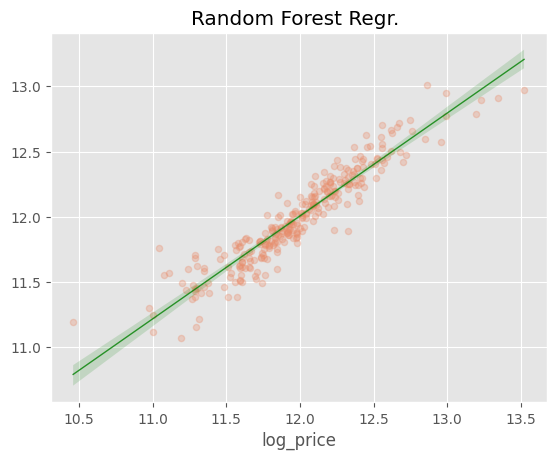

In [95]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Random Forest Regr. ")
plt.show()

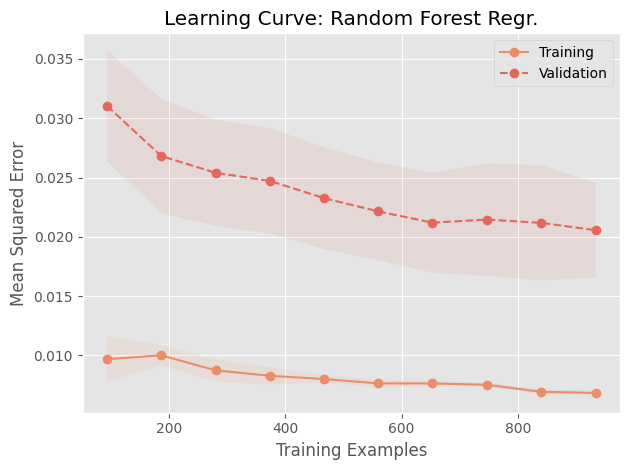

In [96]:
from utils import plot_learning_curve

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

val_rfr = RandomForestRegressor(**study.best_params, n_jobs=-1, random_state=2)

plot_learning_curve(val_rfr, X_train, y_train, title="Learning Curve: Random Forest Regr.")
plt.show()

In [97]:
metrics = {
    'model': 'RFR',
    'params': f'{study.best_params}',
    'RMSE': round(rmse, 4),
    'R2': round(r2, 4)
}

metrics = pd.DataFrame(metrics, index=[0])

ridge_metrics = pd.read_csv(os.path.join(METRICS_PATH, '0100_metrics.csv'), index_col=0)

metrics = pd.concat([ridge_metrics, metrics])

metrics.to_csv(os.path.join(METRICS_PATH, '0200_metrics.csv'))

In [98]:
data.to_csv(os.path.join(RAW_PATH, '0200_data_ohe.csv'))